# Covid detection and Classification

### Import all the Dependencies

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:
#pip install tensorflow

### Set all the Constants

In [5]:
BATCH_SIZE = 16
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=30

In [11]:
import os

In [13]:
os.chdir('path')

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [19]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 224 files belonging to 2 classes.


In [26]:
class_names = dataset.class_names
class_names

['Covid', 'Normal']

In [28]:
for image_batch, labels_batch in dataset.take(1): # take first batch of the images
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 224, 224, 3)
[1 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0]


In [30]:
# labels_batch # is a tensor convert them into numpy

In [32]:
#image_batch #is also tensor contains batch=32 images with 3 colors

In [34]:
class_names[labels_batch[1]] # 1 indicates index of above line

'Normal'

In [36]:
class_names[labels_batch[2]] #if index value =0 ...> covid and 1 ...> Normal

'Normal'

In [38]:
class_names[labels_batch[9]]

'Covid'

As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

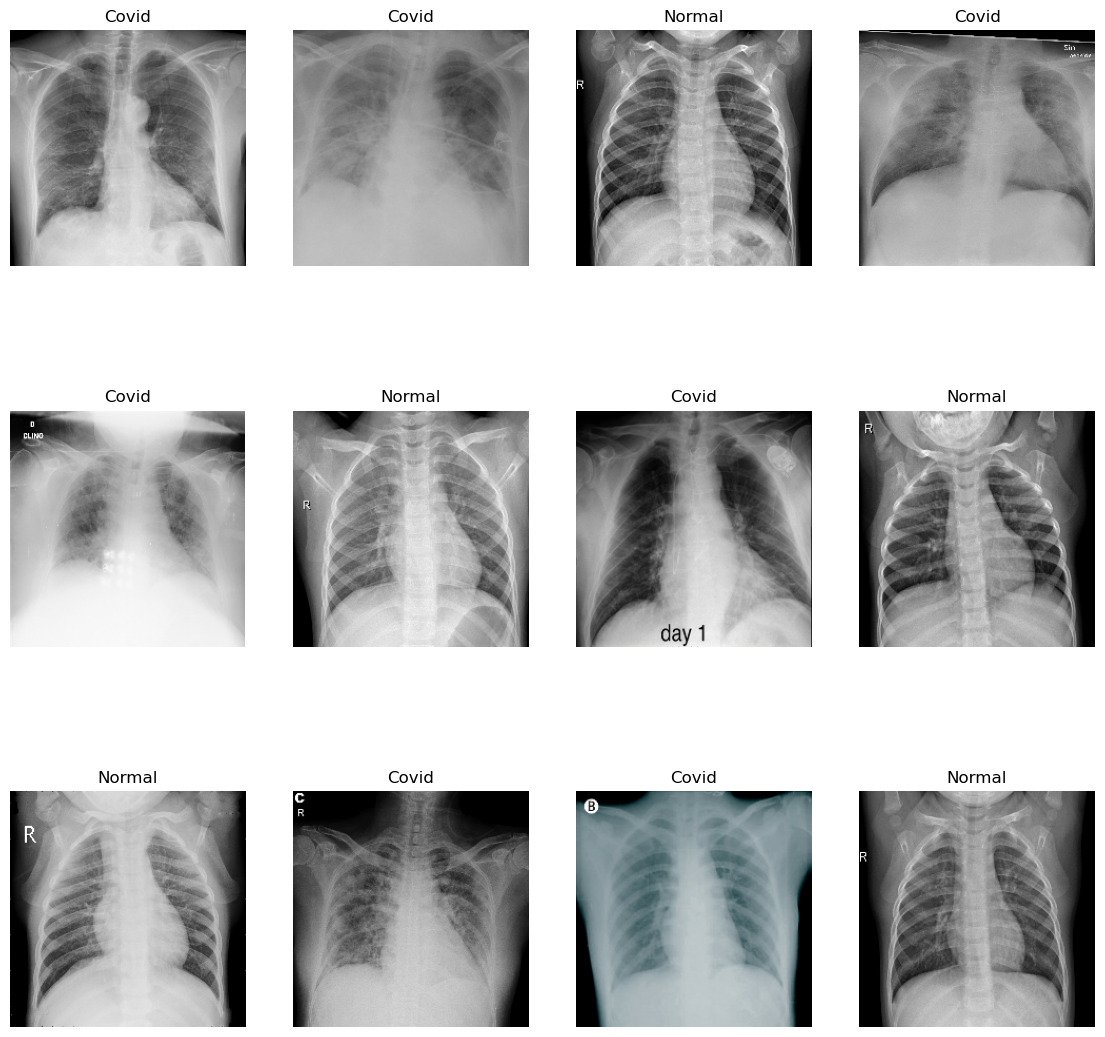

In [42]:
plt.figure(figsize=(14, 14))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [47]:
train_ds=dataset

In [49]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Val",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 60 files belonging to 2 classes.


### Cache, Shuffle, and Prefetch the Dataset

Cache speed-up in getting the data. prefetch preprocess the data while training in parallel. Its more usful with GPU's

In [53]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [65]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [68]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [71]:
# Augmentation is applied only to training data. Not required for validation and testing
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture
We use a CNN coupled with a Sigmoid activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [99]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])

model.build(input_shape=input_shape)

In [101]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (16, 222, 222, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (16, 111, 111, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (16, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (16, 54, 54, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (16, 52, 52, 64)         

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [104]:
from tensorflow.keras.optimizers.legacy import Adam

In [106]:
'''learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)'''

"learning_rate = 0.0001\noptimizer = Adam(learning_rate=learning_rate)\nmodel.compile(\n    optimizer=optimizer,\n    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),\n    metrics=['accuracy']\n)"

In [108]:
### Compile the CNN Model (alternatively optimizer="RMSprop")
from tensorflow.keras.optimizers.legacy import Adam
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [110]:
model.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.0001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [112]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=test_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/30
14/14 [==============================] - 4s 195ms/step - loss: 0.6934 - accuracy: 0.4777 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/30
14/14 [==============================] - 2s 173ms/step - loss: 0.6928 - accuracy: 0.5491 - val_loss: 0.6917 - val_accuracy: 0.6333
Epoch 3/30
14/14 [==============================] - 2s 175ms/step - loss: 0.6923 - accuracy: 0.5045 - val_loss: 0.6906 - val_accuracy: 0.5000
Epoch 4/30
14/14 [==============================] - 3s 176ms/step - loss: 0.6912 - accuracy: 0.5000 - val_loss: 0.6885 - val_accuracy: 0.5000
Epoch 5/30
14/14 [==============================] - 3s 179ms/step - loss: 0.6902 - accuracy: 0.5000 - val_loss: 0.6871 - val_accuracy: 0.5000
Epoch 6/30
14/14 [==============================] - 3s 176ms/step - loss: 0.6873 - accuracy: 0.5848 - val_loss: 0.6822 - val_accuracy: 0.5000
Epoch 7/30
14/14 [==============================] - 2s 176ms/step - loss: 0.6847 - accuracy: 0.5268 - val_loss: 0.6760 - val_accuracy: 0.8167
Epoch 

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [464]:
history

In [466]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 14}

In [467]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [469]:
type(history.history['loss'])

list

In [470]:
len(history.history['loss'])

30

In [471]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.6928536295890808,
 0.6904698610305786,
 0.6877389550209045,
 0.6825790405273438,
 0.6733744740486145]

In [472]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [473]:
len(range(EPOCHS))

30

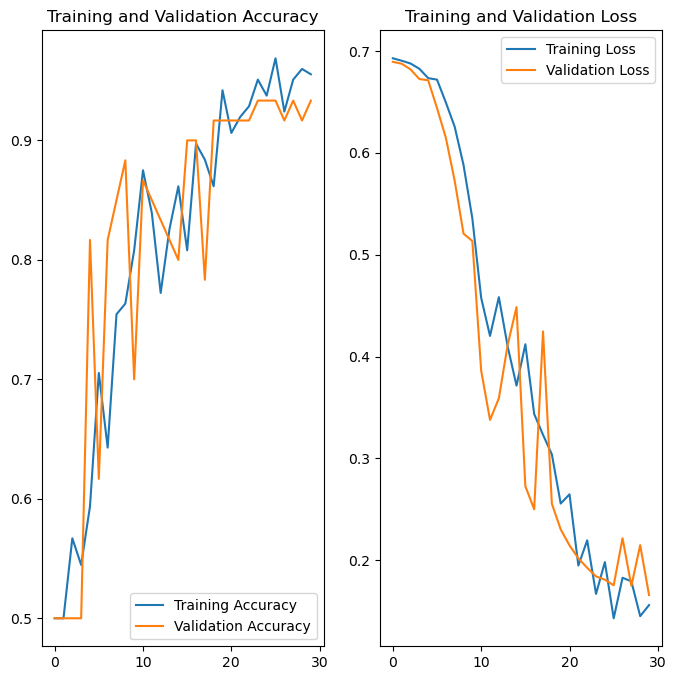

In [474]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Transfer leraning with VGG-16

In [148]:
import glob
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [150]:
from keras.applications.vgg16 import VGG16

vgg = VGG16(input_shape=(IMAGE_SIZE,IMAGE_SIZE, CHANNELS), weights='imagenet',include_top=False)

for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)

In [152]:
#folders = glob('Users/sambasivaraokambala/Downloads/MLDL/Github/dog_cat/cats_and_dogs_filtered/train/*')

#prediction = Dense(len(folders), activation='sigmoid')(x)
prediction = Dense(1, activation='sigmoid')(x)

model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [154]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [156]:
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=test_ds,
    verbose=1,
    epochs=5)

Epoch 1/5
14/14 [==============================] - 19s 1s/step - loss: 2.1626 - accuracy: 0.8170 - val_loss: 2.5022 - val_accuracy: 0.8667
Epoch 2/5
14/14 [==============================] - 19s 1s/step - loss: 0.6519 - accuracy: 0.9464 - val_loss: 0.2922 - val_accuracy: 0.9500
Epoch 3/5
14/14 [==============================] - 19s 1s/step - loss: 0.6292 - accuracy: 0.9598 - val_loss: 2.5684 - val_accuracy: 0.8833
Epoch 4/5
14/14 [==============================] - 19s 1s/step - loss: 0.4299 - accuracy: 0.9643 - val_loss: 0.2537 - val_accuracy: 0.9667
Epoch 5/5
14/14 [==============================] - 19s 1s/step - loss: 0.0530 - accuracy: 0.9911 - val_loss: 0.3321 - val_accuracy: 0.9500


In [ ]:
acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']

loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

In [ ]:
EPOCHS=5

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc1, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss1, label='Training Loss')
plt.plot(range(EPOCHS), val_loss1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.save('Covid_not_TL.h5')

### Run prediction on a sample image

In [476]:
class_names

['Covid', 'Normal']

first image to predict
actual label: Normal
1/1 [==============================] - 0s 74ms/step
predicted label: Normal


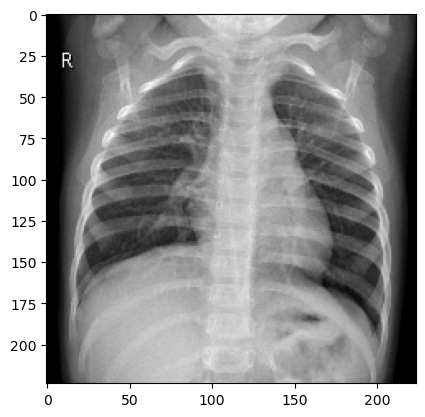

In [477]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):   # batch-1
    
    first_image = images_batch[0].numpy().astype('uint8')  # its the first image
    first_label = labels_batch[0].numpy()     # first image corresponding label
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [478]:
class_names[np.argmax(batch_prediction[0])]

'Normal'

### Write a function for inference

In [480]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 [==============================] - 0s 11ms/step


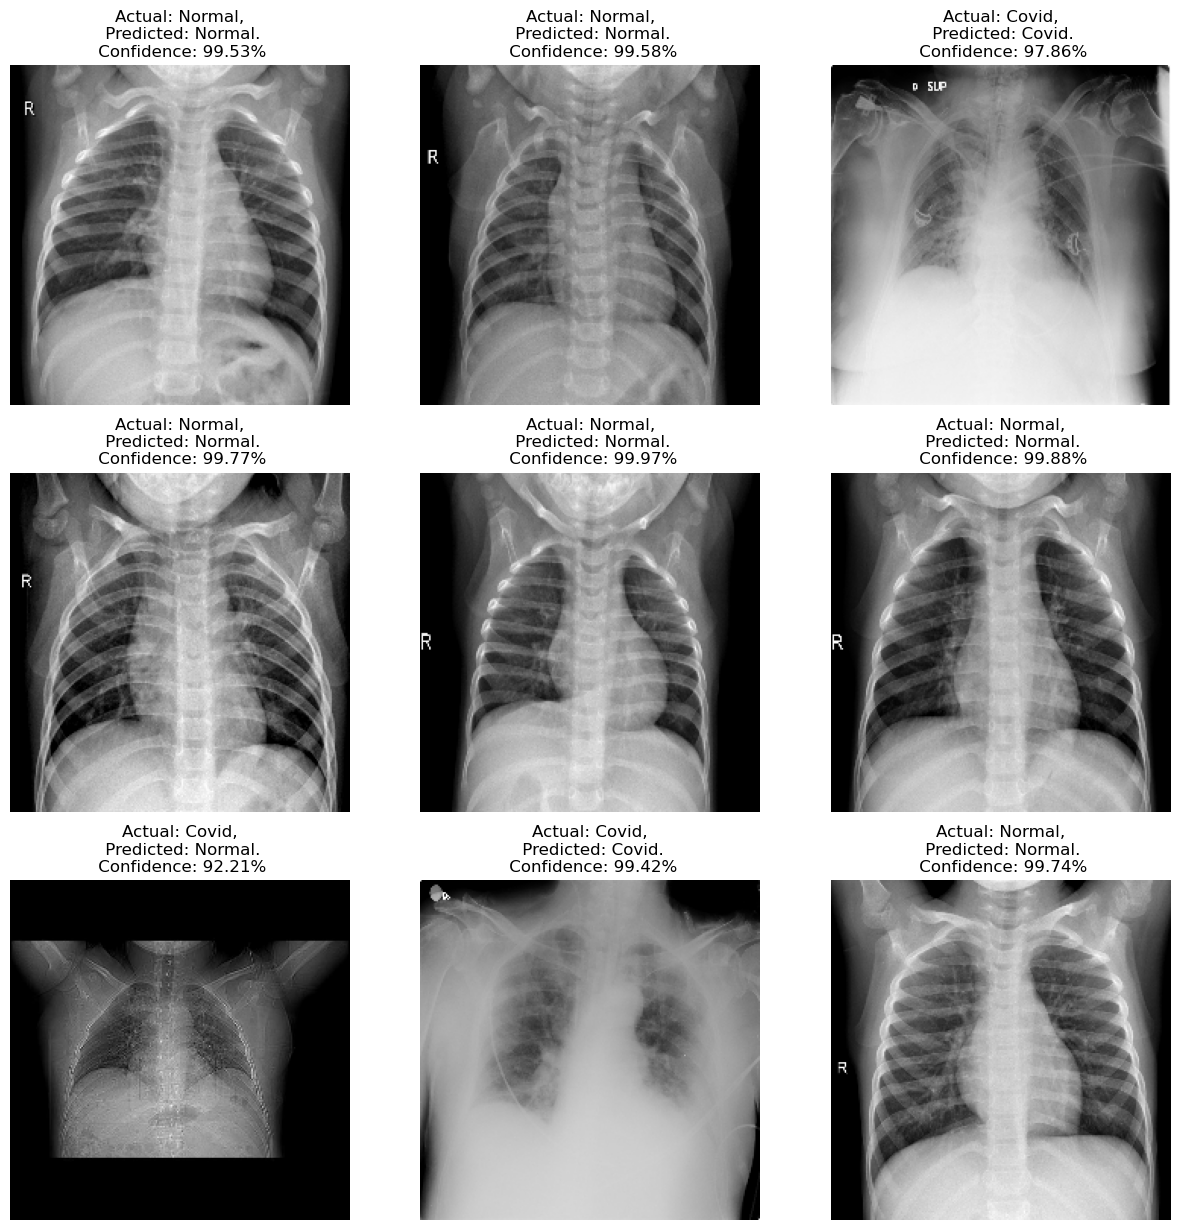

In [482]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [484]:
pwd

'/Users/sambasivaraokambala/Downloads/MLDL/Github/Covid/CovidDataset'

In [485]:
#cd saved_models

[Errno 2] No such file or directory: 'saved_models'
/Users/sambasivaraokambala/Downloads/MLDL/Github/Covid


In [500]:
'''import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")'''

'import os\nmodel_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1\nmodel.save(f"../saved_models/{model_version}")'

In [504]:
model.save("../covid.h5")  # Save the model

In [506]:
pwd

'/Users/sambasivaraokambala/Downloads/MLDL/Github/Covid/CovidDataset'

# Load the model

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
from keras.preprocessing import image
import numpy as np

In [ ]:
import tensorflow as tf

from keras.models import load_model

In [ ]:
pwd

In [ ]:
%cd /Users/sambasivaraokambala/Downloads/MLDL/Github/Potato disease/training # change the directory

In [ ]:
model1=load_model('covid.h5')

# Method-1

In [ ]:
im1=image.load_img('test1.jpg',target_size=(IMAGE_SIZE,IMAGE_SIZE))

In [ ]:
x=image.img_to_array(im1)
x=np.expand_dims(x,axis=0)
clas=model1.predict(x)
clas

# Method-2

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
# predict(model1,im1)
plt.imshow(im1)  
predicted_class, confidence = predict(model1, im1)
actual_class = class_names[labels[i]] 

plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

plt.axis()